# レース結果取得

## 各種インポート

In [56]:
import pandas as pd
import time
from tqdm import tqdm_notebook as tqdm
import requests
from bs4 import BeautifulSoup
import re

In [53]:
def scraping_race_result(id_list, pre_race_results={}):
    race_results = pre_race_results
    
    for race_id in tqdm(id_list):
        if race_id in pre_race_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/race/' + race_id
            df = pd.read_html(url)[0]
            
            #horse_idとjockey_idを入れる
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            
            horse_id_list = []
            horse_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
                
            jockey_id_list = []
            jockey_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])
                
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
            
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return race_results

年＋場所（01:札幌,02:函館,03:福島,04:新潟,05:東京,06:中山,07:中京,08:京都,09:阪神,10:小倉）＋回＋月日＋ラウンド

In [52]:
race_id_list = []
for place in range(1,11,1):
    for kai in range(1,6,1):
        for day in range(1,9,1):
            for r in range(1,13,1):
                race_id = '2019' + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

In [54]:
result_2019 = scraping_race_result(race_id_list)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [59]:
result_2019 = dict_to_pd(result_2019)
result_2019.to_pickle('result_2019.pickle')

In [58]:
#スクレイピング後に辞書型からDataFrame型に変換
def dict_to_pd(data):
    for key in data.keys():
        data[key].index = [key]*len(data[key])
    df = pd.concat([data[key] for key in data.keys()],sort=False)
    return df

## スクレイピング後のデータ

In [259]:
result = pd.read_pickle('result_2020.pickle')
result.head()

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id
202106030811,1,4,7,エフフォーリア,牡3,57.0,横山武史,2:00.6,NaN,3.7,2.0,504(-10),[東] 鹿戸雄一,2018105027,01170
202106030811,2,7,13,タイトルホルダー,牡3,57.0,田辺裕信,2:01.1,3,17,8.0,462(-4),[東] 栗田徹,2018103559,01075
202106030811,3,2,3,ステラヴェローチェ,牡3,57.0,吉田隼人,2:01.1,クビ,14.3,6.0,500(0),[西] 須貝尚介,2018104980,01095
202106030811,4,1,1,アドマイヤハダル,牡3,57.0,ルメール,2:01.2,クビ,8.8,3.0,482(-2),[西] 大久保龍,2018105092,05339
202106030811,5,3,6,ヨーホーレイク,牡3,57.0,岩田望来,2:01.2,クビ,21.5,11.0,504(-2),[西] 友道康夫,2018105012,01174


# レース情報取得

In [261]:
race_id_list = result.index.unique()
len(race_id_list)

3121

In [10]:
def scrape_race_info(race_id_list):
    race_infos = {}
    
    for race_id in tqdm(race_id_list):
        try:
            url = 'https://db.netkeiba.com/race/' +race_id
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            texts = soup.find('div',attrs=['class','data_intro']).find_all('p')[0].text + \
                soup.find('div',attrs=['class','data_intro']).find_all('p')[1].text
            info = re.findall(r'\w+', texts)
            #infoに含まれるtextの内容によって項目を判断
            info_dict = {}
            for text in info:
                if text in ['芝','ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = re.findall(r'\d+',text)[0]
                if text in ['良','稍重','重','不良']:
                    info_dict['ground_state'] = text
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text
            race_infos[race_id] = info_dict
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return pd.DataFrame(race_infos).T

## スクレイピング後のデータ

In [258]:
race_infos = pd.read_pickle('race_infos.pickle')
race_infos.index.nunique()

3120

## データをマージして前処理

In [17]:
def preprocessing(race_result):
    df = race_result.copy()
    #着順から数字以外を含むデータを除く
    df = df[-df["着順"].astype(str).str.contains("\D")] 
    #性齢を性と齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
    #馬体重を体重と体重増減に分ける
    df["体重"] = df["馬体重"].str.split('(',expand=True)[0].astype(int)
    df["体重増減"] = df["馬体重"].str.split('(',expand=True)[1].str[:-1].astype(int)
    #型変換と不要列削除
    df["単勝"] = df["単勝"].astype(float)
    df["着順"] = df["着順"].astype(int)
    df["人気"] = df["人気"].astype(int)
    df.drop(['性齢','馬体重','タイム','着差','調教師'], axis=1,inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    df['course_len'] = df['course_len'].astype(int)
    
    return df

In [18]:
result_addinfo = result.merge(race_infos, left_index=True, right_index=True, how='inner')
result_addinfo = preprocessing(result_addinfo)

In [7]:
result_addinfo = pd.read_pickle('result_addinfo.pickle')
result_addinfo.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,性,齢,体重,体重増減,course_len,weather,race_type,ground_state,date
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3.0,牝,2,438,4,1800,曇,芝,良,2020-07-25
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2.0,牡,2,510,0,1800,曇,芝,良,2020-07-25
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1.0,牡,2,482,-6,1800,曇,芝,良,2020-07-25
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4.0,牝,2,442,0,1800,曇,芝,良,2020-07-25
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5.0,牡,2,426,-8,1800,曇,芝,良,2020-07-25


# 馬ごとの過去成績を取得

In [34]:
horse_id_list = result_addinfo['horse_id'].unique()

In [35]:
def scraping_horse_result(id_list, pre_horse_results={}):
    horse_results = pre_horse_results
    
    for horse_id in tqdm(id_list):
        if horse_id in horse_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
            horse_results[horse_id] = df
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return horse_results

In [36]:
horse_results = scraping_horse_result(horse_id_list)

for key in horse_results.keys():
    horse_results[key].index = [key]*len(horse_results[key])
    
horse_results = pd.DataFrame(pd.concat([horse_results[key] for key in horse_results.keys()],sort=False))

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


## スクレイピング後のデータ

In [172]:
horse_results = pd.read_pickle('horse_data.pickle')
horse_results.head(3)

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴
2018101626,2021/04/11,3中山6,晴,7.0,3歳1勝クラス,NaN,10.0,1.0,1.0,52.9,...,**,5-6-6-5,38.0-34.7,34.6,450(+2),NaN,NaN,ミヤビハイディ,NaN,NaN
2018101626,2021/03/27,3中山1,晴,6.0,3歳1勝クラス,NaN,8.0,8.0,8.0,72.1,...,**,8-8-8-8,36.3-36.6,36.3,448(+4),NaN,NaN,スペシャルドラマ,NaN,NaN
2018101626,2021/03/13,2中山5,雨,7.0,3歳1勝クラス,NaN,11.0,6.0,7.0,99.2,...,**,9-9-7-8,37.5-38.2,40.5,444(0),NaN,NaN,ヴァイスメテオール,NaN,NaN


In [175]:
horse_results.columns

Index(['日付', '開催', '天気', 'R', 'レース名', '映像', '頭数', '枠番', '馬番', 'オッズ', '人気',
       '着順', '騎手', '斤量', '距離', '馬場', '馬場指数', 'タイム', '着差', 'ﾀｲﾑ指数', '通過', 'ペース',
       '上り', '馬体重', '厩舎ｺﾒﾝﾄ', '備考', '勝ち馬(2着馬)', '賞金', '受賞歴'],
      dtype='object')

## HorseResultsクラス

In [239]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','R','賞金','開催','距離','タイム']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self):
        df = self.horse_results.copy()
        df = df[-df['R'].isnull()]
        df['賞金'] = df['賞金'].fillna(0).astype('int')
        df['日付'] = pd.to_datetime(df['日付'])
        df.rename(columns={'R':'着順'}, inplace=True)
        df['着順'] = df['着順'].astype('int')
        
        #開催場所
        place_dict = {'札幌':'01', '函館':'02', '福島':'03', '新潟':'04', '東京':'05', 
                      '中山':'06', '中京':'07', '京都':'08', '阪神':'09','小倉':'10'}
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #距離
        df['距離'] = df['距離'].str.extract(r'(\D+)')
        #タイム
        def to_second(x):
            info = re.findall(r'(\d+)', str(x))
            if len(info)==3:
                second = int(info[0]) * 60 + int(info[1])
            else:
                second = 0        
            return second
        
        df['タイム'] = df['タイム'].map(lambda x : to_second(x))
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results[self.horse_results.index.isin(horse_id_list)]
        #平均する対象をレース日付以前のうち直近n_samplesのデータのみに限定する（古いデータを反映させないため）
        if n_samples=='all':
            filtered_df = target_df[target_df['日付'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['日付'] < date].sort_values('日付', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        filtered_df = filtered_df.groupby(level=0)[['着順','賞金']].mean()
        filtered_df.rename(columns={'着順':'着順_{}R'.format(n_samples),'賞金':'賞金_{}R'.format(n_samples)}, inplace=True)
        return filtered_df
    
    def merge(self, results, date, n_samples):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        #レース結果の同じ日付のかたまりごとに1行ずつhorse_idにひもづくその日付以前の戦績の平均を算出し（average）、
        #レース結果のかたまりにマージする(merge)という意味
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)]) 
        return merged_df

In [240]:
hr = HorseResults(horse_results)

In [241]:
hr.horse_results

,日付,着順,賞金,開催,距離,タイム
2018101626,2021-04-11,7,0,06,芝,110
2018101626,2021-03-27,6,0,06,芝,110
2018101626,2021-03-13,7,0,06,芝,131
2018101626,2020-10-03,9,0,06,芝,123
2018101626,2020-09-05,11,0,01,芝,109
...,...,...,...,...,...,...
2014102720,2017-02-19,2,130,08,ダ,74
2014102720,2017-02-12,5,0,08,芝,97
2014102720,2017-01-21,5,0,08,芝,125
2014102720,2016-12-25,4,0,09,芝,125


In [242]:
result_addinfo = pd.read_pickle('result_addinfo_p.pickle')
result_addinfo.head(2)

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,性,齢,体重,体重増減,course_len,weather,race_type,ground_state,date
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,牝,2,438,4,1800,曇,芝,良,2020-07-25
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,牡,2,510,0,1800,曇,芝,良,2020-07-25


In [243]:
result_5R = hr.merge_all(result_addinfo, n_samples=5)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## マージ後のデータ

In [103]:
result_5R.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,齢,体重,体重増減,course_len,weather,race_type,ground_state,date,着順_5R,賞金_5R
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,...,2,438,4,1800,曇,芝,良,2020-07-25,6.0,0.0
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,...,2,510,0,1800,曇,芝,良,2020-07-25,5.0,280.0
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1,2018104800,01032,...,2,482,-6,1800,曇,芝,良,2020-07-25,5.0,280.0
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4,2018102410,01176,...,2,442,0,1800,曇,芝,良,2020-07-25,5.0,70.0
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5,2018100828,01116,...,2,426,-8,1800,曇,芝,良,2020-07-25,5.0,0.0


# レースごとの払い戻しデータを取得

In [143]:
from urllib.request import urlopen

def scraping_return_tables(id_list):
    return_tables = {}
    for race_id in tqdm(id_list):
        try:
            url='https://db.netkeiba.com/race/' + race_id
            f = urlopen(url)
            html = f.read()#バイト型の文字列
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
            
    for key in return_tables.keys():
        return_tables[key].index = [key]*len(return_tables[key])
        
    return_tables_pd = pd.concat([return_tables[key] for key in return_tables.keys()],sort=False)
    return return_tables_pd

## スクレイピング後のデータ

In [129]:
return_tables = pd.read_pickle('return_tables.pickle')
return_tables

,0,1,2,3
202010020706,単勝,4,1350,5
202010020706,複勝,4br12br9,470br160br400,8br2br6
202010020706,枠連,2 - 6,2460,7
202010020706,馬連,4 - 12,2630,9
202010020706,ワイド,4 - 12br4 - 9br9 - 12,"890br3,800br930",8br39br10
...,...,...,...,...
202006050804,馬連,6 - 11,610,1
202006050804,ワイド,6 - 11br6 - 9br9 - 11,"280br1,010br1,520",1br9br16
202006050804,馬単,6 → 11,960,1
202006050804,三連複,6 - 9 - 11,3900,9


## Returnクラス

In [85]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @property
    def tan(self):
        tan = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tan.columns = ['win', 'return']
        
        for column in tan.columns:
            tan[column] = pd.to_numeric(tan[column], errors='coerce')
        return tan
    
    @property
    def fuku(self):
        fuku = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        #勝ち馬の馬番
        wins = fuku[1].str.split('br', expand = True).drop([3,4], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        #払い戻し
        returns = fuku[2].str.split('br', expand = True).drop([3,4], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand = True)[[0,1]].add_prefix('win_')
        returns = umaren[2].rename('return')
        
        df = pd.concat([wins, returns], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする

In [86]:
rt = Return.read_pickle(['return_tables.pickle'])

# 血統データ取得

In [ ]:
def scraping_peds(id_list, pre_peds={}):
    peds = pre_peds
    
    for horse_id in tqdm(id_list):
        if horse_id in pre_peds.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/ped/' + horse_id
            df = pd.read_html(url)[0]
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i] #若い世代から順に
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
                
            ped = pd.concat(generations[i] for i in range(5)).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(0.1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
    return peds

In [246]:
horse_id_list = horse_results.index.unique()
peds = scraping_peds(horse_id_list)
peds = pd.concat([peds[horse_id] for horse_id in peds], axis=1).T
peds = peds.add_prefix('peds_')

11389

## スクレイピング後のデータ

In [247]:
peds = pd.read_pickle('peds.pickle')
peds.head(2)

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,ゴールドシップ 2009 芦毛 [血統][産駒] Halo系,コスモエルデスト 2011 鹿毛 [血統][産駒] FNo.[14-f],ステイゴールド 1994 黒鹿毛 [血統][産駒],ポイントフラッグ 1998 芦毛 [血統][産駒],ブラックホーク 1994 鹿毛 [血統][産駒],ビューティアイ 2005 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],メジロマックイーン 1987 芦毛 [血統][産駒],パストラリズム 1987 黒鹿毛 [血統][産駒],...,Chieftain,Level Sands,Halo,Wishing Well,Carr de Naskra,Mawgrit,Danzig,Razyana,リアルシャダイ,マックスビューティ
2018105193,ディープインパクト 2002 鹿毛 [血統][産駒] Halo系,ヒストリックスター 2005 鹿毛 [血統][産駒] FNo.[9-f],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ベガ 1990 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Alzao 1980 鹿毛 [血統][産駒],Burghclere 1977 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Kalamoun,State Pension,Hornbeam,Priddy Fair,Nearctic,Natalma,Tom Fool,Brazen


In [251]:
results_ped = result_5R.merge(peds, left_on='horse_id', right_index=True, how='left')
results_ped.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,...,Chieftain,Level Sands,Halo,Wishing Well,Carr de Naskra,Mawgrit,Danzig,Razyana,リアルシャダイ,マックスビューティ
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,...,Lithiot,Nenana Road,Kalamoun,State Pension,Hornbeam,Priddy Fair,Nearctic,Natalma,Tom Fool,Brazen
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1,2018104800,01032,...,Welsh Pageant,Electric Flash,Sir Gaylord,Little Hut,Claude,Ribasha,Thatch,Last Call,Mummy's Pet,Goosie-Gantlet
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4,2018102410,01176,...,Bustino,Zerbinetta,Danzig,Foreign Courier,Ahonoora,Balidaress,Arctic Tern,Beaune,Nureyev,Unite
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5,2018100828,01116,...,Lithiot,Nenana Road,Nearctic,Natalma,Victoria Park,Lady Angela,Herbager,Silver Sari,Crimson Satan,Bright Prospect


## Pedsクラス

In [68]:
from sklearn.preprocessing import LabelEncoder

class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_en = pd.DataFrame()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_en = df.astype('category')

In [69]:
pe = Peds.read_pickle(['peds.pickle'])
pe.encode()

In [70]:
pe.peds_en

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,253,2123,165,370,762,4026,96,168,230,372,...,56,333,63,370,72,485,87,821,1312,3114
2018105193,338,4804,154,237,749,4445,35,152,6,33,...,182,415,78,330,178,617,246,668,926,305
2018104800,289,5971,145,396,279,489,75,3,198,356,...,374,162,155,190,88,672,389,538,561,923
2018102410,224,7325,175,256,346,5456,96,162,156,191,...,51,645,35,106,9,50,19,89,606,2418
2018100828,446,3244,141,291,749,3521,46,189,203,319,...,182,415,109,230,451,417,153,930,204,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018109169,290,2300,75,106,668,2523,13,113,86,245,...,432,606,17,146,361,108,484,1131,1050,2789
2017104830,282,3891,182,282,450,371,96,157,178,337,...,119,308,178,365,106,693,174,663,413,659
2017101519,345,5319,141,325,748,3133,46,189,198,377,...,220,493,139,152,275,939,147,198,960,1501
2018106621,435,6246,139,375,646,4387,72,26,206,307,...,424,702,129,119,270,757,287,903,580,2422


# 前処理

## データをカテゴリ変数化、ダミー変数化

In [252]:
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
        
    df2 = pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

In [253]:
#3着以内に入るかどうかを判定するrank列を追加し、不要な列を削除
results_ped["rank"] = results_ped["着順"].map(lambda x:1 if x <4 else 0)
results_ped.drop(["馬名","着順","騎手","単勝","人気"],axis=1, inplace=True)

In [254]:
cat_columns = ['horse_id'] + list(peds.columns)
results_d = process_categorical(results_ped, cat_columns)

In [94]:
results_d = pd.read_pickle('results_d.pickle')
results_d.head()

,枠番,馬番,斤量,horse_id,齢,体重,体重増減,course_len,date,着順_5R,...,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重
202001010101,6,6,54.0,8763,2,438,4,1800,2020-07-25,6.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,2,2,54.0,10421,2,510,0,1800,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,3,3,54.0,10170,2,482,-6,1800,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,1,1,52.0,9127,2,442,0,1800,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,4,4,54.0,8488,2,426,-8,1800,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0


In [13]:
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    train.drop(['date'],axis=1,inplace=True)
    test.drop(['date'],axis=1,inplace=True)
    return train, test

In [14]:
#被説明変数をrankにし、訓練データとテストデータに分割
train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

# モデル作成と結果検証

## ModelEvaluatorクラス

In [126]:
from scipy.special import comb

class ModelEvaluator:
    def __init__(self, model, return_table, std=True):
        self.model = model
        self.tan = Return(return_table).tan
        self.fuku = Return(return_table).fuku
        self.umaren = Return(return_table).umaren
        self.std = std
        
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x-x.mean())/x.std()
            proba = proba.groupby(level=0).transform(standard_scaler) #標準化
            proba = (proba - proba.min())/(proba.max() - proba.min()) #MinMaxスケーリング
        return proba
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
    
    def tan_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.tan.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
       
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money
            
    def fuku_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def umaren_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds), 2) #レースごとに3着以内予想馬から2頭を選ぶ買い方の数
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']]).issubset(set(preds)) #bool値が入る
        money = (self.umaren.index.map(hit).values * self.umaren['return']).sum()
        return n_bets, money
        

In [159]:
#回収率計算
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money =return_func(X, threshold)
        if n_bets>lower:
            gain[n_bets] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [129]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score

params = {
    'num_leaves':3, #デフォルトは34
    'n_estimators':70,
    'min_data_in_leaf':300,
    'class_weight':'balanced',
    'random_state':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) 

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


LGBMClassifier(class_weight='balanced', min_data_in_leaf=300, n_estimators=70,
               num_leaves=3, random_state=100)

In [130]:
me = ModelEvaluator(lgb_clf, return_tables)

In [132]:
#特徴量
me.feature_importance(X_test).head(10) 

,features,importance
9,賞金_5R,32
3,horse_id,22
128,jockey_id_01088,12
5,体重,12
215,jockey_id_05339,12
2,斤量,7
93,jockey_id_01014,7
8,着順_5R,6
78,jockey_id_00666,5
42,peds_32,3


In [133]:
fuku = gain(me.fuku_return, X_test)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


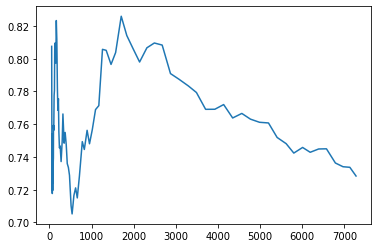

In [135]:
fuku.plot()

## パラメータチューニング

In [95]:
#訓練データをさらに分割
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

train, test = split_data(results_d)
train, valid = split_data(train)

In [96]:
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

* 訓練データ→検証データの学習をパラメータを変えながら実行
* verbose_eval：何回の学習でパラメータを変えるか
* early_stopping_rounds：パラメータの種類（下記では10）を変更しても精度が上がらない場合学習を止める

In [30]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective':'binary', #2値予測の場合
    'random_state':100
}

lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid), 
                        verbose_eval=100, 
                        early_stopping_rounds=10)

[I 2021-06-23 10:28:51,279] A new study created in memory with name: no-name-d5d06b06-d4b4-48ea-b6b1-22c8504b150a


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.490683:   0%|                                                     | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 0.490683:  14%|######4                                      | 1/7 [00:02<00:13,  2.19s/it][I 2021-06-23 10:28:53,490] Trial 0 finished with value: 0.4906833225987821 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4906833225987821.


feature_fraction, val_score: 0.490683:  14%|######4                                      | 1/7 [00:02<00:13,  2.19s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.437682	valid_1's binary_logloss: 0.490683
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.490672:  14%|######4                                      | 1/7 [00:04<00:13,  2.19s/it]

feature_fraction, val_score: 0.490672:  29%|############8                                | 2/7 [00:04<00:10,  2.12s/it][I 2021-06-23 10:28:55,439] Trial 1 finished with value: 0.4906724771021838 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.4906724771021838.


feature_fraction, val_score: 0.490672:  29%|############8                                | 2/7 [00:04<00:10,  2.12s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428829	valid_1's binary_logloss: 0.490672
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.489143:  29%|############8                                | 2/7 [00:06<00:10,  2.12s/it]

feature_fraction, val_score: 0.489143:  43%|###################2                         | 3/7 [00:06<00:08,  2.23s/it][I 2021-06-23 10:28:57,932] Trial 2 finished with value: 0.48914323349374766 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.48914323349374766.


feature_fraction, val_score: 0.489143:  43%|###################2                         | 3/7 [00:06<00:08,  2.23s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.414071	valid_1's binary_logloss: 0.489143
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.489143:  43%|###################2                         | 3/7 [00:08<00:08,  2.23s/it]

feature_fraction, val_score: 0.489143:  57%|#########################7                   | 4/7 [00:08<00:06,  2.23s/it][I 2021-06-23 10:29:00,156] Trial 3 finished with value: 0.49040462120355366 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.48914323349374766.


feature_fraction, val_score: 0.489143:  57%|#########################7                   | 4/7 [00:08<00:06,  2.23s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.426167	valid_1's binary_logloss: 0.490405
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.489143:  57%|#########################7                   | 4/7 [00:11<00:06,  2.23s/it]

feature_fraction, val_score: 0.489143:  71%|################################1            | 5/7 [00:11<00:04,  2.21s/it][I 2021-06-23 10:29:02,328] Trial 4 finished with value: 0.48991816285561557 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.48914323349374766.


feature_fraction, val_score: 0.489143:  71%|################################1            | 5/7 [00:11<00:04,  2.21s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.411393	valid_1's binary_logloss: 0.489918
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.489143:  71%|################################1            | 5/7 [00:13<00:04,  2.21s/it]

feature_fraction, val_score: 0.489143:  86%|######################################5      | 6/7 [00:13<00:02,  2.22s/it][I 2021-06-23 10:29:04,554] Trial 5 finished with value: 0.49089718788543435 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.48914323349374766.


feature_fraction, val_score: 0.489143:  86%|######################################5      | 6/7 [00:13<00:02,  2.22s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.421158	valid_1's binary_logloss: 0.490897
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction, val_score: 0.489143:  86%|######################################5      | 6/7 [00:15<00:02,  2.22s/it]

feature_fraction, val_score: 0.489143: 100%|#############################################| 7/7 [00:15<00:00,  2.20s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.489143:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.422729	valid_1's binary_logloss: 0.490336
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489143:   0%|                                                          | 0/20 [00:02<?, ?it/s]

num_leaves, val_score: 0.489143:   5%|##5                                               | 1/20 [00:02<00:42,  2.26s/it][I 2021-06-23 10:29:08,965] Trial 7 finished with value: 0.4891565427938946 and parameters: {'num_leaves': 75}. Best is trial 7 with value: 0.4891565427938946.


num_leaves, val_score: 0.489143:   5%|##5                                               | 1/20 [00:02<00:42,  2.26s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.388395	valid_1's binary_logloss: 0.489157
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489143:   5%|##5                                               | 1/20 [00:04<00:42,  2.26s/it]

num_leaves, val_score: 0.489143:  10%|#####                                             | 2/20 [00:04<00:41,  2.32s/it][I 2021-06-23 10:29:11,426] Trial 8 finished with value: 0.49215877790934837 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.4891565427938946.


num_leaves, val_score: 0.489143:  10%|#####                                             | 2/20 [00:04<00:41,  2.32s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.37566	valid_1's binary_logloss: 0.492159
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  10%|#####                                             | 2/20 [00:06<00:41,  2.32s/it]

num_leaves, val_score: 0.489017:  15%|#######5                                          | 3/20 [00:06<00:38,  2.25s/it][I 2021-06-23 10:29:13,520] Trial 9 finished with value: 0.4890170242002899 and parameters: {'num_leaves': 36}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  15%|#######5                                          | 3/20 [00:06<00:38,  2.25s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.411226	valid_1's binary_logloss: 0.489017
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  15%|#######5                                          | 3/20 [00:09<00:38,  2.25s/it]

num_leaves, val_score: 0.489017:  20%|##########                                        | 4/20 [00:09<00:40,  2.53s/it][I 2021-06-23 10:29:16,696] Trial 10 finished with value: 0.4973784773824547 and parameters: {'num_leaves': 243}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  20%|##########                                        | 4/20 [00:10<00:40,  2.53s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.338954	valid_1's binary_logloss: 0.497378
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  20%|##########                                        | 4/20 [00:12<00:40,  2.53s/it]

num_leaves, val_score: 0.489017:  25%|############5                                     | 5/20 [00:12<00:39,  2.63s/it][I 2021-06-23 10:29:19,550] Trial 11 finished with value: 0.4957564135259376 and parameters: {'num_leaves': 239}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  25%|############5                                     | 5/20 [00:12<00:39,  2.63s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.366713	valid_1's binary_logloss: 0.495756
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  25%|############5                                     | 5/20 [00:15<00:39,  2.63s/it]

num_leaves, val_score: 0.489017:  30%|###############                                   | 6/20 [00:15<00:35,  2.51s/it][I 2021-06-23 10:29:21,785] Trial 12 finished with value: 0.49028739093055235 and parameters: {'num_leaves': 67}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  30%|###############                                   | 6/20 [00:15<00:35,  2.51s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.404827	valid_1's binary_logloss: 0.490287
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  30%|###############                                   | 6/20 [00:17<00:35,  2.51s/it]

num_leaves, val_score: 0.489017:  35%|#################5                                | 7/20 [00:17<00:31,  2.42s/it][I 2021-06-23 10:29:23,994] Trial 13 finished with value: 0.492270649643295 and parameters: {'num_leaves': 77}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  35%|#################5                                | 7/20 [00:17<00:31,  2.42s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.404095	valid_1's binary_logloss: 0.492271
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  35%|#################5                                | 7/20 [00:20<00:31,  2.42s/it]

num_leaves, val_score: 0.489017:  40%|####################                              | 8/20 [00:20<00:30,  2.54s/it][I 2021-06-23 10:29:26,817] Trial 14 finished with value: 0.4940933808279574 and parameters: {'num_leaves': 122}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  40%|####################                              | 8/20 [00:20<00:30,  2.54s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.341758	valid_1's binary_logloss: 0.494093
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  40%|####################                              | 8/20 [00:23<00:30,  2.54s/it]

num_leaves, val_score: 0.489017:  45%|######################5                           | 9/20 [00:23<00:30,  2.80s/it][I 2021-06-23 10:29:30,225] Trial 15 finished with value: 0.49842657844933663 and parameters: {'num_leaves': 255}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  45%|######################5                           | 9/20 [00:23<00:30,  2.80s/it]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.310508	valid_1's binary_logloss: 0.498427
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  45%|######################5                           | 9/20 [00:25<00:30,  2.80s/it]

num_leaves, val_score: 0.489017:  50%|########################5                        | 10/20 [00:25<00:25,  2.57s/it][I 2021-06-23 10:29:32,265] Trial 16 finished with value: 0.48960600161441065 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  50%|########################5                        | 10/20 [00:25<00:25,  2.57s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.420179	valid_1's binary_logloss: 0.489606
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  50%|########################5                        | 10/20 [00:28<00:25,  2.57s/it]

num_leaves, val_score: 0.489017:  55%|##########################9                      | 11/20 [00:28<00:24,  2.76s/it][I 2021-06-23 10:29:35,465] Trial 17 finished with value: 0.4955358588836276 and parameters: {'num_leaves': 189}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  55%|##########################9                      | 11/20 [00:28<00:24,  2.76s/it]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.341313	valid_1's binary_logloss: 0.495536
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.481988	valid_1's binary_logloss: 0.493817




num_leaves, val_score: 0.489017:  55%|##########################9                      | 11/20 [00:30<00:24,  2.76s/it]

num_leaves, val_score: 0.489017:  60%|#############################4                   | 12/20 [00:30<00:20,  2.53s/it][I 2021-06-23 10:29:37,477] Trial 18 finished with value: 0.49162762397352033 and parameters: {'num_leaves': 2}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  60%|#############################4                   | 12/20 [00:30<00:20,  2.53s/it]

[200]	valid_0's binary_logloss: 0.476994	valid_1's binary_logloss: 0.491717
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.477174	valid_1's binary_logloss: 0.491628
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  60%|#############################4                   | 12/20 [00:32<00:20,  2.53s/it]

num_leaves, val_score: 0.489017:  65%|###############################8                 | 13/20 [00:32<00:16,  2.42s/it][I 2021-06-23 10:29:39,611] Trial 19 finished with value: 0.4898661279952681 and parameters: {'num_leaves': 32}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  65%|###############################8                 | 13/20 [00:32<00:16,  2.42s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.421672	valid_1's binary_logloss: 0.489866
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  65%|###############################8                 | 13/20 [00:35<00:16,  2.42s/it]

num_leaves, val_score: 0.489017:  70%|##################################3              | 14/20 [00:35<00:14,  2.49s/it][I 2021-06-23 10:29:42,269] Trial 20 finished with value: 0.4942894185551945 and parameters: {'num_leaves': 162}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  70%|##################################3              | 14/20 [00:35<00:14,  2.49s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.364222	valid_1's binary_logloss: 0.494289
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  70%|##################################3              | 14/20 [00:37<00:14,  2.49s/it]

num_leaves, val_score: 0.489017:  75%|####################################7            | 15/20 [00:37<00:11,  2.39s/it][I 2021-06-23 10:29:44,440] Trial 21 finished with value: 0.4906074301816082 and parameters: {'num_leaves': 41}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  75%|####################################7            | 15/20 [00:37<00:11,  2.39s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.408769	valid_1's binary_logloss: 0.490607
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.475038	valid_1's binary_logloss: 0.491137




num_leaves, val_score: 0.489017:  75%|####################################7            | 15/20 [00:39<00:11,  2.39s/it]

num_leaves, val_score: 0.489017:  80%|#######################################2         | 16/20 [00:39<00:09,  2.31s/it][I 2021-06-23 10:29:46,558] Trial 22 finished with value: 0.48930327153051256 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  80%|#######################################2         | 16/20 [00:39<00:09,  2.31s/it]

[200]	valid_0's binary_logloss: 0.467392	valid_1's binary_logloss: 0.489415
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.468025	valid_1's binary_logloss: 0.489303
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  80%|#######################################2         | 16/20 [00:42<00:09,  2.31s/it]

num_leaves, val_score: 0.489017:  85%|#########################################6       | 17/20 [00:42<00:07,  2.36s/it][I 2021-06-23 10:29:49,020] Trial 23 finished with value: 0.49215877790934837 and parameters: {'num_leaves': 97}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  85%|#########################################6       | 17/20 [00:42<00:07,  2.36s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.37566	valid_1's binary_logloss: 0.492159
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  85%|#########################################6       | 17/20 [00:44<00:07,  2.36s/it]

num_leaves, val_score: 0.489017:  90%|############################################1    | 18/20 [00:44<00:04,  2.36s/it][I 2021-06-23 10:29:51,381] Trial 24 finished with value: 0.49049482243500403 and parameters: {'num_leaves': 58}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  90%|############################################1    | 18/20 [00:44<00:04,  2.36s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.390379	valid_1's binary_logloss: 0.490495
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




num_leaves, val_score: 0.489017:  90%|############################################1    | 18/20 [00:47<00:04,  2.36s/it]

num_leaves, val_score: 0.489017:  95%|##############################################5  | 19/20 [00:47<00:02,  2.50s/it][I 2021-06-23 10:29:54,196] Trial 25 finished with value: 0.4949901555365115 and parameters: {'num_leaves': 134}. Best is trial 9 with value: 0.4890170242002899.


num_leaves, val_score: 0.489017:  95%|##############################################5  | 19/20 [00:47<00:02,  2.50s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.355564	valid_1's binary_logloss: 0.49499
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.481988	valid_1's binary_logloss: 0.493817




num_leaves, val_score: 0.489017:  95%|##############################################5  | 19/20 [00:49<00:02,  2.50s/it]

num_leaves, val_score: 0.489017: 100%|#################################################| 20/20 [00:49<00:00,  2.48s/it]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.489017:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[200]	valid_0's binary_logloss: 0.476994	valid_1's binary_logloss: 0.491717
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.477174	valid_1's binary_logloss: 0.491628
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.489017:   0%|                                                             | 0/10 [00:01<?, ?it/s]

bagging, val_score: 0.489017:  10%|#####3                                               | 1/10 [00:01<00:17,  1.95s/it][I 2021-06-23 10:29:58,282] Trial 27 finished with value: 0.4919600327407065 and parameters: {'bagging_fraction': 0.6354892948991177, 'bagging_freq': 4}. Best is trial 27 with value: 0.4919600327407065.


bagging, val_score: 0.489017:  10%|#####3                                               | 1/10 [00:01<00:17,  1.95s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.433806	valid_1's binary_logloss: 0.49196
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.489017:  10%|#####3                                               | 1/10 [00:03<00:17,  1.95s/it]

bagging, val_score: 0.489017:  20%|##########6                                          | 2/10 [00:03<00:15,  1.96s/it][I 2021-06-23 10:30:00,268] Trial 28 finished with value: 0.49196332212589783 and parameters: {'bagging_fraction': 0.6307491049580696, 'bagging_freq': 6}. Best is trial 27 with value: 0.4919600327407065.


bagging, val_score: 0.489017:  20%|##########6                                          | 2/10 [00:03<00:15,  1.96s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.432041	valid_1's binary_logloss: 0.491963
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  20%|##########6                                          | 2/10 [00:06<00:15,  1.96s/it]

bagging, val_score: 0.488382:  30%|###############9                                     | 3/10 [00:06<00:14,  2.00s/it][I 2021-06-23 10:30:02,351] Trial 29 finished with value: 0.48838228476860995 and parameters: {'bagging_fraction': 0.8748484604822779, 'bagging_freq': 1}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  30%|###############9                                     | 3/10 [00:06<00:14,  2.00s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419703	valid_1's binary_logloss: 0.488382
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  30%|###############9                                     | 3/10 [00:08<00:14,  2.00s/it]

bagging, val_score: 0.488382:  40%|#####################2                               | 4/10 [00:08<00:12,  2.00s/it][I 2021-06-23 10:30:04,365] Trial 30 finished with value: 0.4915584935168798 and parameters: {'bagging_fraction': 0.8300054889979509, 'bagging_freq': 4}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  40%|#####################2                               | 4/10 [00:08<00:12,  2.00s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.440095	valid_1's binary_logloss: 0.491558
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  40%|#####################2                               | 4/10 [00:10<00:12,  2.00s/it]

bagging, val_score: 0.488382:  50%|##########################5                          | 5/10 [00:10<00:10,  2.01s/it][I 2021-06-23 10:30:06,402] Trial 31 finished with value: 0.48997727919624 and parameters: {'bagging_fraction': 0.8727948467065229, 'bagging_freq': 7}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  50%|##########################5                          | 5/10 [00:10<00:10,  2.01s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.430146	valid_1's binary_logloss: 0.489977
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  50%|##########################5                          | 5/10 [00:11<00:10,  2.01s/it]

bagging, val_score: 0.488382:  60%|###############################8                     | 6/10 [00:11<00:07,  1.98s/it][I 2021-06-23 10:30:08,314] Trial 32 finished with value: 0.49156486208220906 and parameters: {'bagging_fraction': 0.7043746726367256, 'bagging_freq': 1}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  60%|###############################8                     | 6/10 [00:11<00:07,  1.98s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.433245	valid_1's binary_logloss: 0.491565
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  60%|###############################8                     | 6/10 [00:13<00:07,  1.98s/it]

bagging, val_score: 0.488382:  70%|#####################################                | 7/10 [00:13<00:05,  1.93s/it][I 2021-06-23 10:30:10,135] Trial 33 finished with value: 0.4928865935577238 and parameters: {'bagging_fraction': 0.5792385334408622, 'bagging_freq': 5}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  70%|#####################################                | 7/10 [00:13<00:05,  1.93s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.441507	valid_1's binary_logloss: 0.492887
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  70%|#####################################                | 7/10 [00:15<00:05,  1.93s/it]

bagging, val_score: 0.488382:  80%|##########################################4          | 8/10 [00:15<00:04,  2.01s/it][I 2021-06-23 10:30:12,317] Trial 34 finished with value: 0.49260826897061794 and parameters: {'bagging_fraction': 0.7812461498745709, 'bagging_freq': 7}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  80%|##########################################4          | 8/10 [00:16<00:04,  2.01s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.412522	valid_1's binary_logloss: 0.492608
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  80%|##########################################4          | 8/10 [00:17<00:04,  2.01s/it]

bagging, val_score: 0.488382:  90%|###############################################7     | 9/10 [00:17<00:01,  1.98s/it][I 2021-06-23 10:30:14,244] Trial 35 finished with value: 0.4924368704700378 and parameters: {'bagging_fraction': 0.6458415494413563, 'bagging_freq': 3}. Best is trial 29 with value: 0.48838228476860995.


bagging, val_score: 0.488382:  90%|###############################################7     | 9/10 [00:17<00:01,  1.98s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.43083	valid_1's binary_logloss: 0.492437
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




bagging, val_score: 0.488382:  90%|###############################################7     | 9/10 [00:20<00:01,  1.98s/it]

bagging, val_score: 0.488382: 100%|####################################################| 10/10 [00:20<00:00,  2.03s/it]


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.488382:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.407205	valid_1's binary_logloss: 0.490215
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:   0%|                                              | 0/6 [00:02<?, ?it/s]

feature_fraction_stage2, val_score: 0.488382:  17%|######3                               | 1/6 [00:02<00:10,  2.20s/it][I 2021-06-23 10:30:18,816] Trial 37 finished with value: 0.490582383802579 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 0.490582383802579.


feature_fraction_stage2, val_score: 0.488382:  17%|######3                               | 1/6 [00:02<00:10,  2.20s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.413383	valid_1's binary_logloss: 0.490582
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:  17%|######3                               | 1/6 [00:04<00:10,  2.20s/it]

feature_fraction_stage2, val_score: 0.488382:  33%|############6                         | 2/6 [00:04<00:08,  2.15s/it][I 2021-06-23 10:30:20,835] Trial 38 finished with value: 0.49068597579782985 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.490582383802579.


feature_fraction_stage2, val_score: 0.488382:  33%|############6                         | 2/6 [00:04<00:08,  2.15s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.426069	valid_1's binary_logloss: 0.490686
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:  33%|############6                         | 2/6 [00:06<00:08,  2.15s/it]

feature_fraction_stage2, val_score: 0.488382:  50%|###################                   | 3/6 [00:06<00:06,  2.26s/it][I 2021-06-23 10:30:23,368] Trial 39 finished with value: 0.49015918116748713 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 39 with value: 0.49015918116748713.


feature_fraction_stage2, val_score: 0.488382:  50%|###################                   | 3/6 [00:06<00:06,  2.26s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.391997	valid_1's binary_logloss: 0.490159
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:  50%|###################                   | 3/6 [00:08<00:06,  2.26s/it]

feature_fraction_stage2, val_score: 0.488382:  67%|#########################3            | 4/6 [00:08<00:04,  2.24s/it][I 2021-06-23 10:30:25,544] Trial 40 finished with value: 0.48966240287875684 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 40 with value: 0.48966240287875684.


feature_fraction_stage2, val_score: 0.488382:  67%|#########################3            | 4/6 [00:08<00:04,  2.24s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.405425	valid_1's binary_logloss: 0.489662
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:  67%|#########################3            | 4/6 [00:11<00:04,  2.24s/it]

feature_fraction_stage2, val_score: 0.488382:  83%|###############################6      | 5/6 [00:11<00:02,  2.22s/it][I 2021-06-23 10:30:27,714] Trial 41 finished with value: 0.4899903379206493 and parameters: {'feature_fraction': 0.62}. Best is trial 40 with value: 0.48966240287875684.


feature_fraction_stage2, val_score: 0.488382:  83%|###############################6      | 5/6 [00:11<00:02,  2.22s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.418442	valid_1's binary_logloss: 0.48999
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




feature_fraction_stage2, val_score: 0.488382:  83%|###############################6      | 5/6 [00:13<00:02,  2.22s/it]

feature_fraction_stage2, val_score: 0.488382: 100%|######################################| 6/6 [00:13<00:00,  2.23s/it]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.488382:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.41481	valid_1's binary_logloss: 0.490511
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488366:   0%|                                              | 0/20 [00:02<?, ?it/s]

regularization_factors, val_score: 0.488366:   5%|#9                                    | 1/20 [00:02<00:47,  2.49s/it][I 2021-06-23 10:30:32,498] Trial 43 finished with value: 0.48836595511369585 and parameters: {'lambda_l1': 0.00010092563142876027, 'lambda_l2': 0.0015319564276706887}. Best is trial 43 with value: 0.48836595511369585.


regularization_factors, val_score: 0.488366:   5%|#9                                    | 1/20 [00:02<00:47,  2.49s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.418314	valid_1's binary_logloss: 0.488366
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488366:   5%|#9                                    | 1/20 [00:04<00:47,  2.49s/it]

regularization_factors, val_score: 0.488366:  10%|###8                                  | 2/20 [00:04<00:43,  2.43s/it][I 2021-06-23 10:30:34,792] Trial 44 finished with value: 0.4899900954522247 and parameters: {'lambda_l1': 1.65210073026451e-08, 'lambda_l2': 3.5383759472521}. Best is trial 43 with value: 0.48836595511369585.


regularization_factors, val_score: 0.488366:  10%|###8                                  | 2/20 [00:04<00:43,  2.43s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.43226	valid_1's binary_logloss: 0.48999
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488366:  10%|###8                                  | 2/20 [00:07<00:43,  2.43s/it]

regularization_factors, val_score: 0.488366:  15%|#####7                                | 3/20 [00:07<00:41,  2.42s/it][I 2021-06-23 10:30:37,178] Trial 45 finished with value: 0.49081092982284846 and parameters: {'lambda_l1': 4.122816454603244e-07, 'lambda_l2': 5.172959613262262}. Best is trial 43 with value: 0.48836595511369585.


regularization_factors, val_score: 0.488366:  15%|#####7                                | 3/20 [00:07<00:41,  2.42s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.433822	valid_1's binary_logloss: 0.490811
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  15%|#####7                                | 3/20 [00:09<00:41,  2.42s/it]

regularization_factors, val_score: 0.488155:  20%|#######6                              | 4/20 [00:09<00:38,  2.41s/it][I 2021-06-23 10:30:39,553] Trial 46 finished with value: 0.48815533226813074 and parameters: {'lambda_l1': 0.004898604040497841, 'lambda_l2': 1.6502555673761292e-06}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  20%|#######6                              | 4/20 [00:09<00:38,  2.41s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419726	valid_1's binary_logloss: 0.488155
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  20%|#######6                              | 4/20 [00:11<00:38,  2.41s/it]

regularization_factors, val_score: 0.488155:  25%|#########5                            | 5/20 [00:12<00:36,  2.42s/it][I 2021-06-23 10:30:42,006] Trial 47 finished with value: 0.4902662776736114 and parameters: {'lambda_l1': 1.5006375699020853e-06, 'lambda_l2': 0.3682831865621876}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  25%|#########5                            | 5/20 [00:12<00:36,  2.42s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.424353	valid_1's binary_logloss: 0.490266
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  25%|#########5                            | 5/20 [00:14<00:36,  2.42s/it]

regularization_factors, val_score: 0.488155:  30%|###########4                          | 6/20 [00:14<00:33,  2.40s/it][I 2021-06-23 10:30:44,369] Trial 48 finished with value: 0.4907641448764938 and parameters: {'lambda_l1': 0.08009262183710111, 'lambda_l2': 3.7364027707415133e-07}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  30%|###########4                          | 6/20 [00:14<00:33,  2.40s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.424114	valid_1's binary_logloss: 0.490764
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  30%|###########4                          | 6/20 [00:16<00:33,  2.40s/it]

regularization_factors, val_score: 0.488155:  35%|#############3                        | 7/20 [00:16<00:31,  2.46s/it][I 2021-06-23 10:30:46,960] Trial 49 finished with value: 0.48827027830406783 and parameters: {'lambda_l1': 3.9146952653368e-05, 'lambda_l2': 0.002545064077718234}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  35%|#############3                        | 7/20 [00:16<00:31,  2.46s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.400484	valid_1's binary_logloss: 0.48827
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  35%|#############3                        | 7/20 [00:19<00:31,  2.46s/it]

regularization_factors, val_score: 0.488155:  40%|###############2                      | 8/20 [00:19<00:29,  2.49s/it][I 2021-06-23 10:30:49,506] Trial 50 finished with value: 0.4906902335276521 and parameters: {'lambda_l1': 0.0005188551005975501, 'lambda_l2': 0.43394743293227933}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  40%|###############2                      | 8/20 [00:19<00:29,  2.49s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.40505	valid_1's binary_logloss: 0.49069
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  40%|###############2                      | 8/20 [00:22<00:29,  2.49s/it]

regularization_factors, val_score: 0.488155:  45%|#################1                    | 9/20 [00:22<00:28,  2.56s/it][I 2021-06-23 10:30:52,250] Trial 51 finished with value: 0.49022157111368003 and parameters: {'lambda_l1': 0.03144513700126321, 'lambda_l2': 5.89678561731961}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  45%|#################1                    | 9/20 [00:22<00:28,  2.56s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.410892	valid_1's binary_logloss: 0.490222
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  45%|#################1                    | 9/20 [00:24<00:28,  2.56s/it]

regularization_factors, val_score: 0.488155:  50%|##################5                  | 10/20 [00:24<00:24,  2.49s/it][I 2021-06-23 10:30:54,579] Trial 52 finished with value: 0.48886310589616616 and parameters: {'lambda_l1': 1.457270169573487e-07, 'lambda_l2': 0.03139333080166209}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  50%|##################5                  | 10/20 [00:24<00:24,  2.49s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.426017	valid_1's binary_logloss: 0.488863
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  50%|##################5                  | 10/20 [00:26<00:24,  2.49s/it]

regularization_factors, val_score: 0.488155:  55%|####################3                | 11/20 [00:26<00:22,  2.45s/it][I 2021-06-23 10:30:56,939] Trial 53 finished with value: 0.49173069258535057 and parameters: {'lambda_l1': 8.95536831513883, 'lambda_l2': 1.0355414905512514e-06}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  55%|####################3                | 11/20 [00:26<00:22,  2.45s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.43881	valid_1's binary_logloss: 0.491731
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  55%|####################3                | 11/20 [00:29<00:22,  2.45s/it]

regularization_factors, val_score: 0.488155:  60%|######################2              | 12/20 [00:29<00:19,  2.40s/it][I 2021-06-23 10:30:59,200] Trial 54 finished with value: 0.48838224675403913 and parameters: {'lambda_l1': 0.0001447046491852206, 'lambda_l2': 1.0543579201540247e-05}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  60%|######################2              | 12/20 [00:29<00:19,  2.40s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419703	valid_1's binary_logloss: 0.488382
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  60%|######################2              | 12/20 [00:31<00:19,  2.40s/it]

regularization_factors, val_score: 0.488155:  65%|########################             | 13/20 [00:31<00:16,  2.40s/it][I 2021-06-23 10:31:01,601] Trial 55 finished with value: 0.48836052161006194 and parameters: {'lambda_l1': 0.007069635141294541, 'lambda_l2': 5.404018035175503e-05}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  65%|########################             | 13/20 [00:31<00:16,  2.40s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419681	valid_1's binary_logloss: 0.488361
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  65%|########################             | 13/20 [00:33<00:16,  2.40s/it]

regularization_factors, val_score: 0.488155:  70%|#########################9           | 14/20 [00:33<00:14,  2.36s/it][I 2021-06-23 10:31:03,869] Trial 56 finished with value: 0.4883822831047734 and parameters: {'lambda_l1': 7.148540420531381e-06, 'lambda_l2': 2.164517107974998e-08}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  70%|#########################9           | 14/20 [00:33<00:14,  2.36s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419703	valid_1's binary_logloss: 0.488382
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  70%|#########################9           | 14/20 [00:36<00:14,  2.36s/it]

regularization_factors, val_score: 0.488155:  75%|###########################7         | 15/20 [00:36<00:12,  2.49s/it][I 2021-06-23 10:31:06,672] Trial 57 finished with value: 0.48973498363383233 and parameters: {'lambda_l1': 2.583417037017869, 'lambda_l2': 0.0007921808455336035}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  75%|###########################7         | 15/20 [00:36<00:12,  2.49s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.396917	valid_1's binary_logloss: 0.489735
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  75%|###########################7         | 15/20 [00:38<00:12,  2.49s/it]

regularization_factors, val_score: 0.488155:  80%|#############################6       | 16/20 [00:38<00:09,  2.39s/it][I 2021-06-23 10:31:08,841] Trial 58 finished with value: 0.4886981300016938 and parameters: {'lambda_l1': 0.0028310848038589627, 'lambda_l2': 0.008683226921824657}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  80%|#############################6       | 16/20 [00:38<00:09,  2.39s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.424074	valid_1's binary_logloss: 0.488698
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  80%|#############################6       | 16/20 [00:41<00:09,  2.39s/it]

regularization_factors, val_score: 0.488155:  85%|###############################4     | 17/20 [00:41<00:07,  2.37s/it][I 2021-06-23 10:31:11,156] Trial 59 finished with value: 0.49024085709160264 and parameters: {'lambda_l1': 0.29378551164928296, 'lambda_l2': 1.7119520820836342e-08}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  85%|###############################4     | 17/20 [00:41<00:07,  2.37s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.415657	valid_1's binary_logloss: 0.490241
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  85%|###############################4     | 17/20 [00:43<00:07,  2.37s/it]

regularization_factors, val_score: 0.488155:  90%|#################################3   | 18/20 [00:43<00:04,  2.34s/it][I 2021-06-23 10:31:13,419] Trial 60 finished with value: 0.4883687317375211 and parameters: {'lambda_l1': 2.2882531638127055e-05, 'lambda_l2': 2.3629730707387684e-05}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  90%|#################################3   | 18/20 [00:43<00:04,  2.34s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419703	valid_1's binary_logloss: 0.488369
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  90%|#################################3   | 18/20 [00:45<00:04,  2.34s/it]

regularization_factors, val_score: 0.488155:  95%|###################################1 | 19/20 [00:45<00:02,  2.37s/it][I 2021-06-23 10:31:15,862] Trial 61 finished with value: 0.4883083235137141 and parameters: {'lambda_l1': 0.0012428113680382283, 'lambda_l2': 8.989944970122136e-07}. Best is trial 46 with value: 0.48815533226813074.


regularization_factors, val_score: 0.488155:  95%|###################################1 | 19/20 [00:45<00:02,  2.37s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.404714	valid_1's binary_logloss: 0.488308
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




regularization_factors, val_score: 0.488155:  95%|###################################1 | 19/20 [00:48<00:02,  2.37s/it]

regularization_factors, val_score: 0.488155: 100%|#####################################| 20/20 [00:48<00:00,  2.41s/it]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.488155:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.419704	valid_1's binary_logloss: 0.488382
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.488155:   0%|                                                     | 0/5 [00:02<?, ?it/s]

min_data_in_leaf, val_score: 0.488155:  20%|#########                                    | 1/5 [00:02<00:09,  2.38s/it][I 2021-06-23 10:31:20,551] Trial 63 finished with value: 0.4894688863207606 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4894688863207606.


min_data_in_leaf, val_score: 0.488155:  20%|#########                                    | 1/5 [00:02<00:09,  2.38s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.426441	valid_1's binary_logloss: 0.489469
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.488155:  20%|#########                                    | 1/5 [00:04<00:09,  2.38s/it]

min_data_in_leaf, val_score: 0.488155:  40%|##################                           | 2/5 [00:04<00:06,  2.32s/it][I 2021-06-23 10:31:22,712] Trial 64 finished with value: 0.4920816259004752 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.4894688863207606.


min_data_in_leaf, val_score: 0.488155:  40%|##################                           | 2/5 [00:04<00:06,  2.32s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.430385	valid_1's binary_logloss: 0.492082
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.488155:  40%|##################                           | 2/5 [00:06<00:06,  2.32s/it]

min_data_in_leaf, val_score: 0.488155:  60%|###########################                  | 3/5 [00:06<00:04,  2.31s/it][I 2021-06-23 10:31:24,994] Trial 65 finished with value: 0.49104706351807015 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.4894688863207606.


min_data_in_leaf, val_score: 0.488155:  60%|###########################                  | 3/5 [00:06<00:04,  2.31s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.420317	valid_1's binary_logloss: 0.491047
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.488155:  60%|###########################                  | 3/5 [00:09<00:04,  2.31s/it]

min_data_in_leaf, val_score: 0.488155:  80%|####################################         | 4/5 [00:09<00:02,  2.32s/it][I 2021-06-23 10:31:27,339] Trial 66 finished with value: 0.49002228798189124 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.4894688863207606.


min_data_in_leaf, val_score: 0.488155:  80%|####################################         | 4/5 [00:09<00:02,  2.32s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.423979	valid_1's binary_logloss: 0.490022
[LightGBM] [Info] Number of positive: 4590, number of negative: 16705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12168
[LightGBM] [Info] Number of data points in the train set: 21295, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215544 -> initscore=-1.291828
[LightGBM] [Info] Start training from score -1.291828
Training until validation scores don't improve for 10 rounds




min_data_in_leaf, val_score: 0.488155:  80%|####################################         | 4/5 [00:11<00:02,  2.32s/it]

min_data_in_leaf, val_score: 0.488155: 100%|#############################################| 5/5 [00:11<00:00,  2.28s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.423547	valid_1's binary_logloss: 0.489467


In [31]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.004898604040497841,
 'lambda_l2': 1.6502555673761292e-06,
 'num_leaves': 36,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8748484604822779,
 'bagging_freq': 1,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

## LightGBM

In [97]:
#被説明変数をrankにし、訓練データとテストデータに分割
train, test = split_data(results_d)
X_train = train.drop(['rank','date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank','date'], axis=1)
y_test = test['rank']

In [98]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score

params = {'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.004898604040497841,
 'lambda_l2': 1.6502555673761292e-06,
 'num_leaves': 36,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8748484604822779,
 'bagging_freq': 1,
 'min_child_samples': 20,
 'num_iterations': 1000}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) 

C:\Users\owner\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.004898604040497841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004898604040497841
[LightGBM] [Warning] bagging_fraction is set=0.8748484604822779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8748484604822779
[LightGBM] [Warning] lambda_l2 is set=1.6502555673761292e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6502555673761292e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8748484604822779, bagging_freq=1,
               feature_fraction=0.7, feature_pre_filter=False,
               lambda_l1=0.004898604040497841, lambda_l2=1.6502555673761292e-06,
               num_iterations=1000, num_leaves=36, objective='binary',
               random_state=100)

In [163]:
fuku2 = gain(me.fuku_return, X_test)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


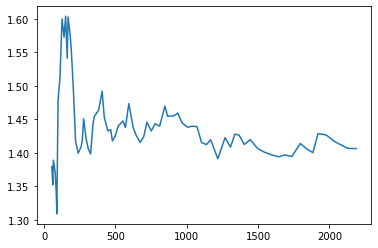

In [164]:
fuku2.plot()

In [47]:
me2.feature_importance(X_test).head(10) #モデルが複雑になるほどfeature_importanceの値は高くなる

,features,importance
9,賞金_5R,2154
8,着順_5R,1453
5,体重,1089
6,体重増減,1063
1,馬番,1039
3,horse_id,773
15,peds_5,718
11,peds_1,711
69,peds_59,685
71,peds_61,677


In [102]:
#回収率計算
def gain2(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money = return_func(X, threshold)
        if n_bets>lower:
            gain[threshold] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [161]:
fuku3 = gain2(me2.fuku_return, X_test)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


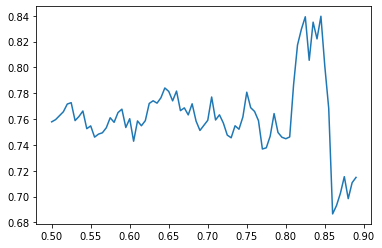

In [162]:
fuku3.plot()

In [156]:
me = ModelEvaluator(lgb_clf, return_tables)
me.umaren_return(X_test)

(1817.0, 15790.0)

In [157]:
umaren = gain2(me.umaren_return, X_test)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


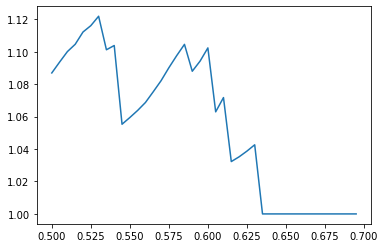

In [158]:
umaren.plot()

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


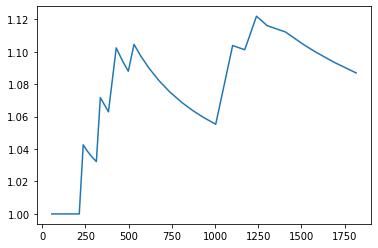

In [160]:
umaren1 = gain(me.umaren_return, X_test)
umaren1.plot()

In [152]:
def merge_data(new_id_list, old_data):
    new_id_list = set(new_id_list) ^ set(old_data.index.unique().values)
    return list(new_id_list)
new_id_list = merge_data(results_d.index.unique(),rt)
return_tables = scraping_return_tables(new_id_list)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [153]:
rt = pd.concat([return_tables, rt])
rt

,0,1,2,3
202001010305,単勝,3,730,4
202001010305,複勝,3br1br9,170br140br130,4br3br2
202001010305,枠連,1 - 3,1550,7
202001010305,馬連,1 - 3,1120,5
202001010305,ワイド,1 - 3br3 - 9br1 - 9,430br420br350,6br5br4
...,...,...,...,...
202006050804,馬連,6 - 11,610,1
202006050804,ワイド,6 - 11br6 - 9br9 - 11,"280br1,010br1,520",1br9br16
202006050804,馬単,6 → 11,960,1
202006050804,三連複,6 - 9 - 11,3900,9


In [155]:
return_tables = pd.read_pickle('return_tables.pickle')

# 最新の出馬表を取得

In [106]:
from selenium.webdriver import Chrome, ChromeOptions
import chromedriver_binary

class Entry_table:
    def __init__(self):
        self.entry_table = pd.DataFrame()
    
    def scraping_table(self, race_id_list):
        options = ChromeOptions()
        driver = Chrome(options=options)
        
        for race_id in race_id_list:
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            driver.get(url)
            elements = driver.find_elements_by_class_name('HorseList')
            for element in elements:
                tds = element.find_elements_by_tag_name('td')
                row = []
                for td in tds:
                    row.append(td.text)
                    if td.get_attribute('class') in ['HorseInfo', 'Jockey']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+', href)[0])
                self.entry_table = self.entry_table.append(pd.Series(row, name = race_id))
            
        driver.close()
        
    def preprocessing(self):
        df = self.entry_table.copy()
        df = df[[0,1,3,4,5,6,7,8,10,11,12]]
        self.entry_table = df
        self.entry_table = self.entry_table.set_axis(['枠', '馬番','馬名','horse_id','性齢','斤量','騎手','jockey_id','馬体重','予想オッズ','人気'], axis=1)
        
    def merge_horse_results(self, horse_results, columns, n_race=5):
        for column in columns:
            df = horse_results.groupby(level=0).head(n_race)
            df = df.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
            df = df.str.split(',', expand=True).add_prefix('{}_'.format(column))
            self.entry_table = self.entry_table.merge(df, left_on='horse_id', right_index=True, how='left')

In [107]:
et = Entry_table()
et.scraping_table(['202105030609'])
et.preprocessing()
et.entry_table

,枠,馬番,馬名,horse_id,性齢,斤量,騎手,jockey_id,馬体重,予想オッズ,人気
202105030609,1,1,ベスビアナイト,2017105590,セ4,54.0,菅原明,01179,490(+2),6.7,5
202105030609,2,2,エドノフェリーチェ,2017104060,牝4,54.0,津村,01092,448(-4),5.1,3
202105030609,3,3,ライル,2016104868,セ5,55.0,石川,01150,490(-10),25.6,7
202105030609,4,4,アスティ,2016104998,セ5,54.0,江田照,00689,430(+4),49.4,9
202105030609,5,5,エカテリンブルク,2017105500,牡4,54.0,石橋脩,01077,510(+4),35.9,8
202105030609,6,6,ディスカバー,2014105545,セ7,53.0,原,01184,466(-2),201.3,11
202105030609,6,7,ドリームスピリット,2015102790,牡6,54.0,ルメール,05339,500(-2),6.5,4
202105030609,7,8,ヒルノダカール,2016100550,牡5,56.0,北村宏,01043,512(+4),11.1,6
202105030609,7,9,ペレ,2016104614,牝5,54.0,Ｍデムーロ,05212,456(-2),3.7,2
202105030609,8,10,レッドクーゲル,2016103041,牡5,53.0,吉田豊,00733,440(-4),80.7,10
